In [ ]:
from pymongo import MongoClient
from elasticsearch import Elasticsearch, helpers
import requests
from IPython.display import JSON
import numpy as np
from fuzzywuzzy import fuzz
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
import math
from colavsim import colav_similarity, parse_doi, parse_string

In [4]:
es = Elasticsearch()

In [5]:
# open a file, where you stored the pickled data
file = open('dataset_full.pkl', 'rb')
# dump information to that file
data = pickle.load(file)
# close the file
file.close()

In [6]:
len(data["p"])

101773

In [7]:
len(data["n"])

41596

In [8]:
data["p"][0]

{'Authors': 'Jaramillo-Ayerbe F., Berrío-Muñoz J.',
 'Title': 'Ivermectin for crusted Norwegian scabies induced by use of topical steroids',
 'Year': 1998,
 'Source title': 'Archives of Dermatology',
 'Volume': '134',
 'Issue': '2',
 'Page start': '143',
 'Page end': '145',
 'DOI': '10.1001/archderm.134.2.143'}

In [9]:
data["n"][0]

{'Authors': 'Flórez G.A.D., Mombello E.E., Voss S.',
 'Title': 'Novel technique for the calculation of eddy current losses and Lorentz forces in foil winding transformers',
 'Year': 2017,
 'Source title': 'International Journal of Applied Electromagnetics and Mechanics',
 'Volume': '55',
 'Issue': '1',
 'Page start': '75',
 'Page end': '88',
 'DOI': '10..3233/JAE-160144'}

In [10]:
scopus = []
#size = 40000
for i in data["p"]:
    scopus.append((i,True))
for i in data["n"]:
    scopus.append((i,False))

In [11]:
es_index = "openalex_parsed"


In [12]:
def get_oa_doi(es_reg):
    for i in es_reg["_source"]['external_ids']:
        if i['source'] == "doi":
            return i["id"]


def get_oa_doi(es_reg):
    return es_reg["_source"]['doi']


In [17]:
def search(Title, Authors, Source, Year, punto_de_corte = 0):
    """
    Definir el valor mínimo del _score que deseas
    Puedes ajustar este valor según tus necesidades

    """
    if not isinstance(Title, str):
        Title = ""
    if not isinstance(Source, str):
        Source = ""
        
        
    body = {
        "query": {
            "bool": {
                "should": [
                    { "match": { "title":  Title }},
                    #{ "match": { "authorships.author.display_name": Authors }},
                    { "match": { "host_venue.display_name":  Source}},
                    { "match": { "publication_year": Year }}
                ]
            }
        },
        "size": 10
    }
    
    res = es.search(index=es_index, **body)
    hits = []
    
    for i in res["hits"]["hits"]:
        if i["_score"] >= punto_de_corte:
            hits.append(i)
    res["hits"]["hits"] = hits
    return  res

In [18]:
%%time

def es_similarity(rec,th = 0):
    res = search(rec['Title'],rec['Authors'],rec['Source title'],rec['Year'],th)
    if len(res["hits"]["hits"]) > 1:
        oa_doi = get_oa_doi(res["hits"]["hits"][0]).replace("https://doi.org/","").lower()
        sc_doi = rec["DOI"].lower()
        if oa_doi == sc_doi:
            return (True,res["hits"]["hits"][0]["_score"])
        else:
            return (False,res["hits"]["hits"][0]["_score"])
np.random.shuffle(data["p"])
np.random.shuffle(data["n"])
for i in data["p"][0:10000]:
    scopus.append((i,True))
for i in data["n"][0:10000]:
    scopus.append((i,False))
np.random.shuffle(scopus) #shuffle is inplace
th=0
results = Parallel(n_jobs=64,backend='threading',verbose=2)(delayed(es_similarity)(rec[0],th) for rec in scopus)


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 237 tasks      | elapsed:    1.4s
[Parallel(n_jobs=64)]: Done 520 tasks      | elapsed:    4.1s
[Parallel(n_jobs=64)]: Done 885 tasks      | elapsed:    7.0s
[Parallel(n_jobs=64)]: Done 1330 tasks      | elapsed:   10.7s
[Parallel(n_jobs=64)]: Done 1857 tasks      | elapsed:   14.5s
[Parallel(n_jobs=64)]: Done 2464 tasks      | elapsed:   18.9s
[Parallel(n_jobs=64)]: Done 3153 tasks      | elapsed:   24.1s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   30.5s
[Parallel(n_jobs=64)]: Done 4773 tasks      | elapsed:   37.9s
[Parallel(n_jobs=64)]: Done 5704 tasks      | elapsed:   45.2s
[Parallel(n_jobs=64)]: Done 6717 tasks      | elapsed:   53.4s
[Parallel(n_jobs=64)]: Done 7810 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 8985 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 10240 tasks 

KeyboardInterrupt: 

In [19]:
results.count(None)

NameError: name 'results' is not defined

In [ ]:
len(results)

In [ ]:
#>tp, tn, fp, fn
actual  = [i[1] for i in scopus]
predicted = [i[0] for i in results]
#predicted = results


In [ ]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
acc = metrics.accuracy_score(actual,predicted)
pre = metrics.precision_score(actual,predicted)
rec = metrics.recall_score(actual,predicted)
f1  = metrics.f1_score(actual,predicted)

print(f"Accuracy  = {acc:.4f}")
print(f"Precision = {pre:.4f}")
print(f"Recall    = {rec:.4f}")
print(f"F1        = {f1:.4f}")


In [208]:
score_p = []
score_n = []
for i in results:
    if i[0]:
        score_p.append(i[1])
    else:
        score_n.append(i[1])


In [209]:
np.max(score_n)

14091.0205

In [210]:
np.min(score_p)

17.427406

In [211]:
np.mean(score_n)

405.4229444101755

In [212]:
np.mean(score_p)

147.83455799785466

In [213]:
f_score_p = []
mean_p = np.mean(score_p)
for i in score_p:
    if i<400:
        f_score_p.append(i)

In [214]:
f_score_n = []
mean_n = np.mean(score_n)
for i in score_n:
    if i<400:
        f_score_n.append(i)

In [215]:
f_score_p = np.array(f_score_p)
f_score_n = np.array(f_score_n)


In [241]:
# Obtiene la información del histograma
valores_p, bordes_p = np.histogram(f_score_p, bins=100, density=True)
centros_p = 0.5 * (bordes_p[:-1] + bordes_p[1:])

# Encuentra el valor máximo en el eje Y
valor_maximo_y_p = max(valores_p)

# Encuentra el valor en el eje X para el cual Y es máximo
valor_maximo_x_p = centros_p[np.argmax(valores_p)]



In [242]:
valor_maximo_x_p

126.40125829

In [243]:
# Obtiene la información del histograma
valores_n, bordes_n = np.histogram(f_score_n, bins=100, density=True)
centros_n = 0.5 * (bordes_n[:-1] + bordes_n[1:])

# Encuentra el valor máximo en el eje Y
valor_maximo_y_n = max(valores_n)

# Encuentra el valor en el eje X para el cual Y es máximo
valor_maximo_x_n = centros_n[np.argmax(valores_n)]

In [244]:
valor_maximo_x_n

33.87606443999999

True

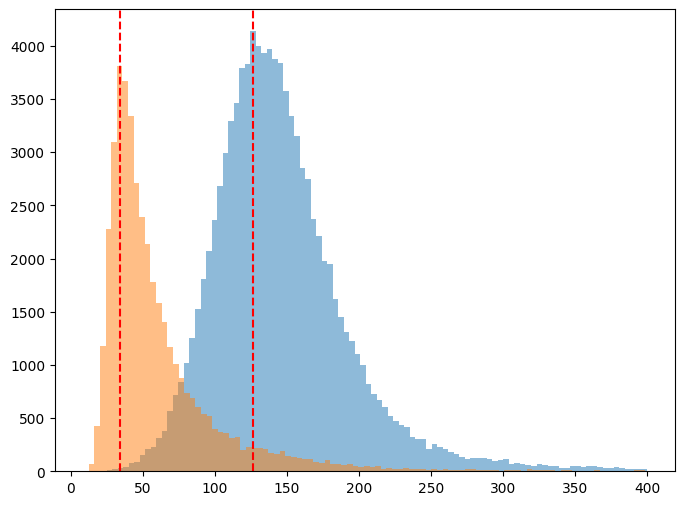

In [245]:
n_bins = 100


plt.figure(figsize=(8,6))
plt.hist(f_score_p, bins=100, alpha=0.5, label="data1", density=False)
plt.hist(f_score_n, bins=100, alpha=0.5, label="data2", density=False)
# Dibuja una línea vertical en el punto máximo
plt.axvline(x=valor_maximo_x_p, color='r', linestyle='--', label=f'Máximo en X: {valor_maximo_x_p:.2f}')
plt.axvline(x=valor_maximo_x_n, color='r', linestyle='--', label=f'Máximo en X: {valor_maximo_x_n:.2f}')

True

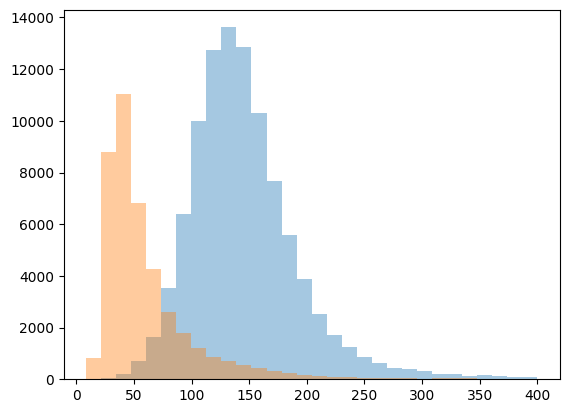

In [217]:
rng = min(f_score_p.min(), f_score_n.min()), max(f_score_p.max(), f_score_n.max())
n1, bins1, _ = plt.hist(f_score_p, alpha=0.4, bins=100, range=rng)
n2, bins2, _ = plt.hist(f_score_n, alpha=0.4, bins=30, range=rng)

10356.0

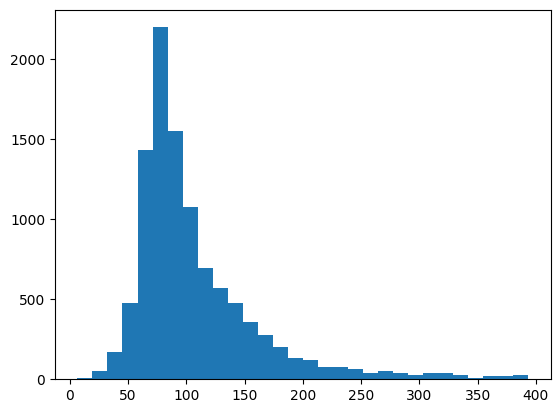

In [167]:
intersection = np.minimum(n1, n2)
area = intersection.sum()
plt.bar(bins1[:-1], intersection, width=bins1[1]- bins1[0])
area

In [168]:
np.max(intersection)

2201.0

In [171]:
bins1


array([ 12.937753  ,  25.83920723,  38.74066147,  51.6421157 ,
        64.54356993,  77.44502417,  90.3464784 , 103.24793263,
       116.14938687, 129.0508411 , 141.95229533, 154.85374957,
       167.7552038 , 180.65665803, 193.55811227, 206.4595665 ,
       219.36102073, 232.26247497, 245.1639292 , 258.06538343,
       270.96683767, 283.8682919 , 296.76974613, 309.67120037,
       322.5726546 , 335.47410883, 348.37556307, 361.2770173 ,
       374.17847153, 387.07992577, 399.98138   ])